In [1]:
import pandas as pd

csv_path = "Sloan Digital Sky Survey.csv"

def load_clean_data(file_path):
    with open(file_path, 'r') as f:
        lines = f.readlines()
    data_lines = [line for line in lines if line.strip() and not line.strip().startswith('#')]
    for idx, line in enumerate(data_lines):
        if 'objid' in line.lower():
            header_idx = idx
            break
    else:
        raise ValueError("Header row with 'objid' not found.")
    from io import StringIO
    cleaned_str = "".join(data_lines[header_idx:])
    df = pd.read_csv(StringIO(cleaned_str))
    return df

df = load_clean_data(csv_path)
df.columns = [col.strip().lower() for col in df.columns]

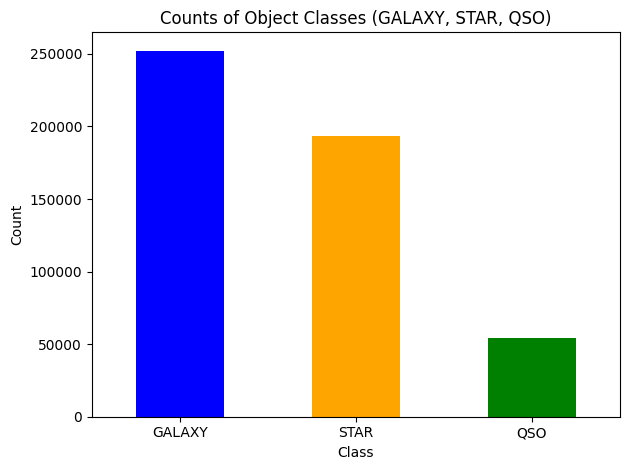

In [2]:
import matplotlib.pyplot as plt

class_counts = df['class'].value_counts()
class_counts.plot(kind='bar', color=['blue', 'orange', 'green'])
plt.title('Counts of Object Classes (GALAXY, STAR, QSO)')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [3]:
features = ['u', 'g', 'r', 'i', 'z']
target = 'class'

for col in features + [target]:
    if col not in df.columns:
        raise ValueError(f"Column '{col}' not found.")

df = df[features + [target]].dropna()

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['class_encoded'] = le.fit_transform(df[target])

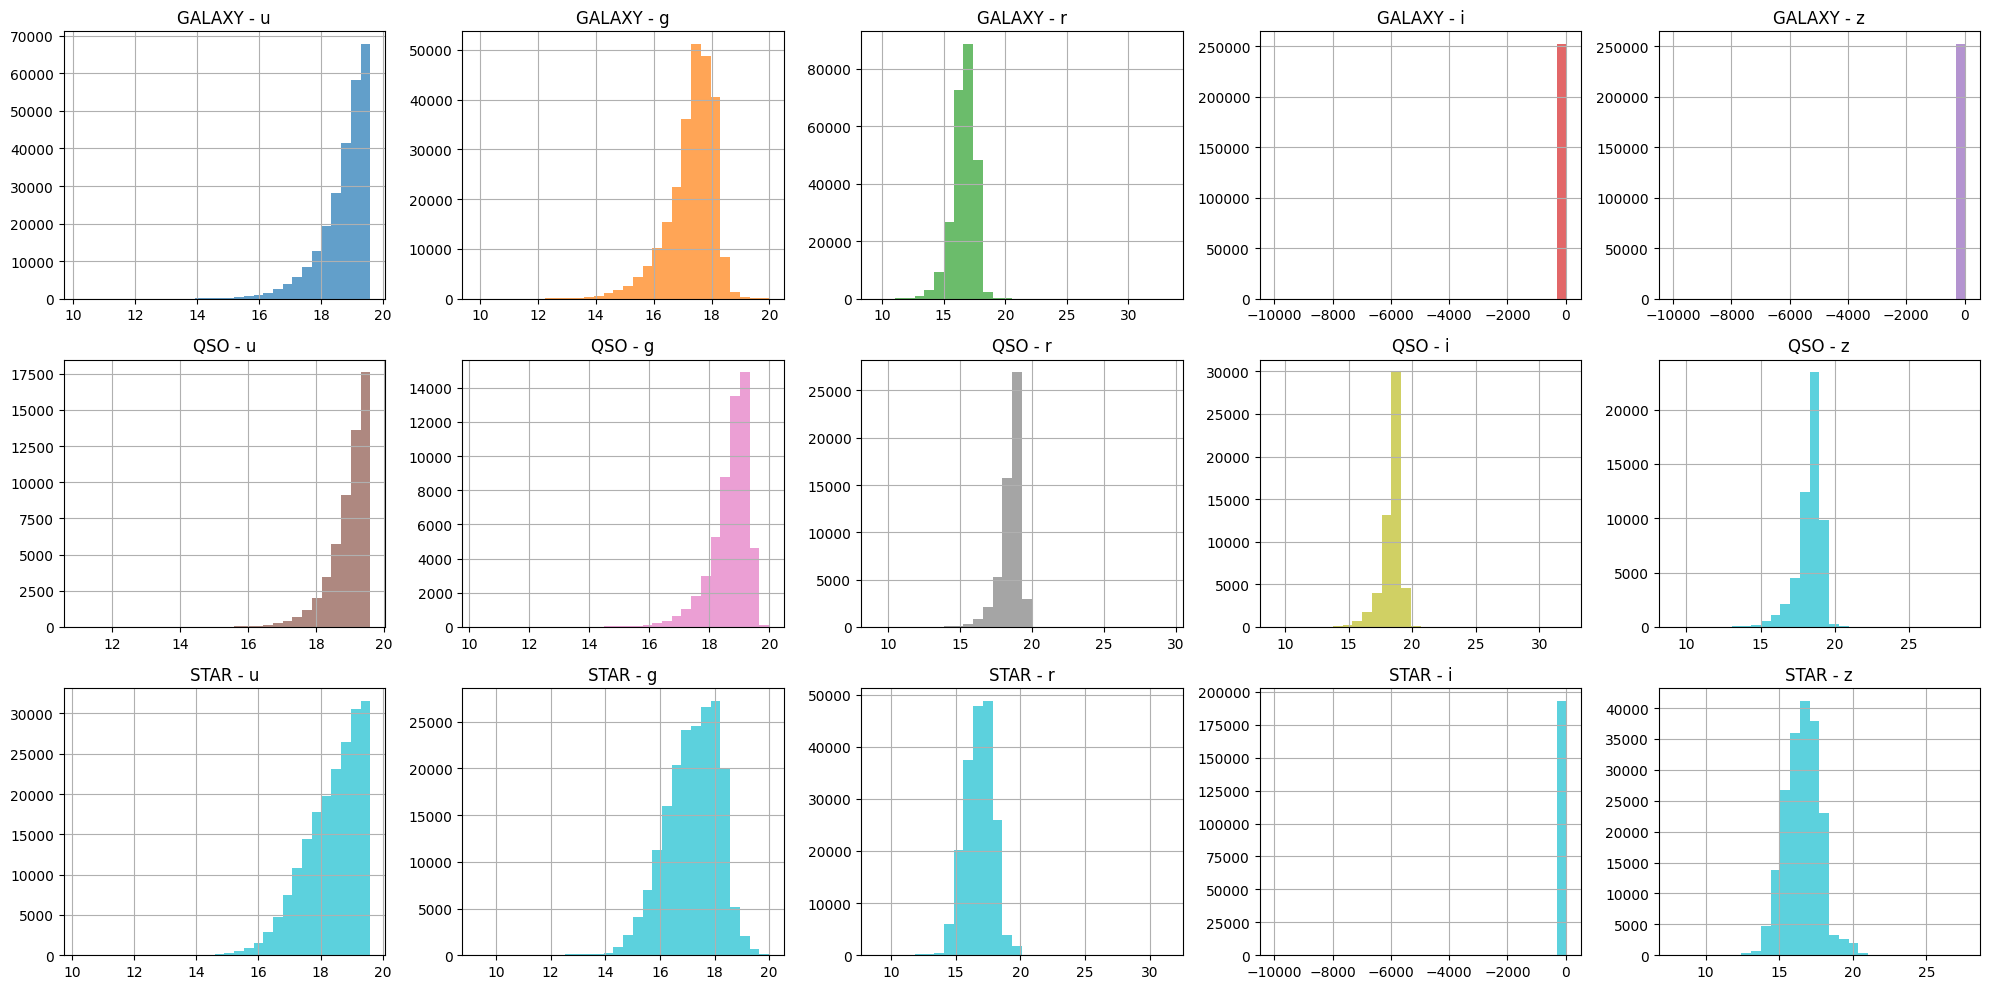

In [4]:
import numpy as np
import matplotlib.pyplot as plt

bands = features
classes = df['class'].unique()
colors = plt.get_cmap('tab10')

fig, axes = plt.subplots(len(classes), len(bands), figsize=(20, 10))

for i, cls in enumerate(classes):
    for j, band in enumerate(bands):
        ax = axes[i, j]
        color_idx = i * len(bands) + j
        df[df['class'] == cls][band].hist(ax=ax, bins=30, alpha=0.7, color=colors(color_idx))
        ax.set_title(f"{cls} - {band}")
        ax.grid(True)

plt.tight_layout()
plt.show()

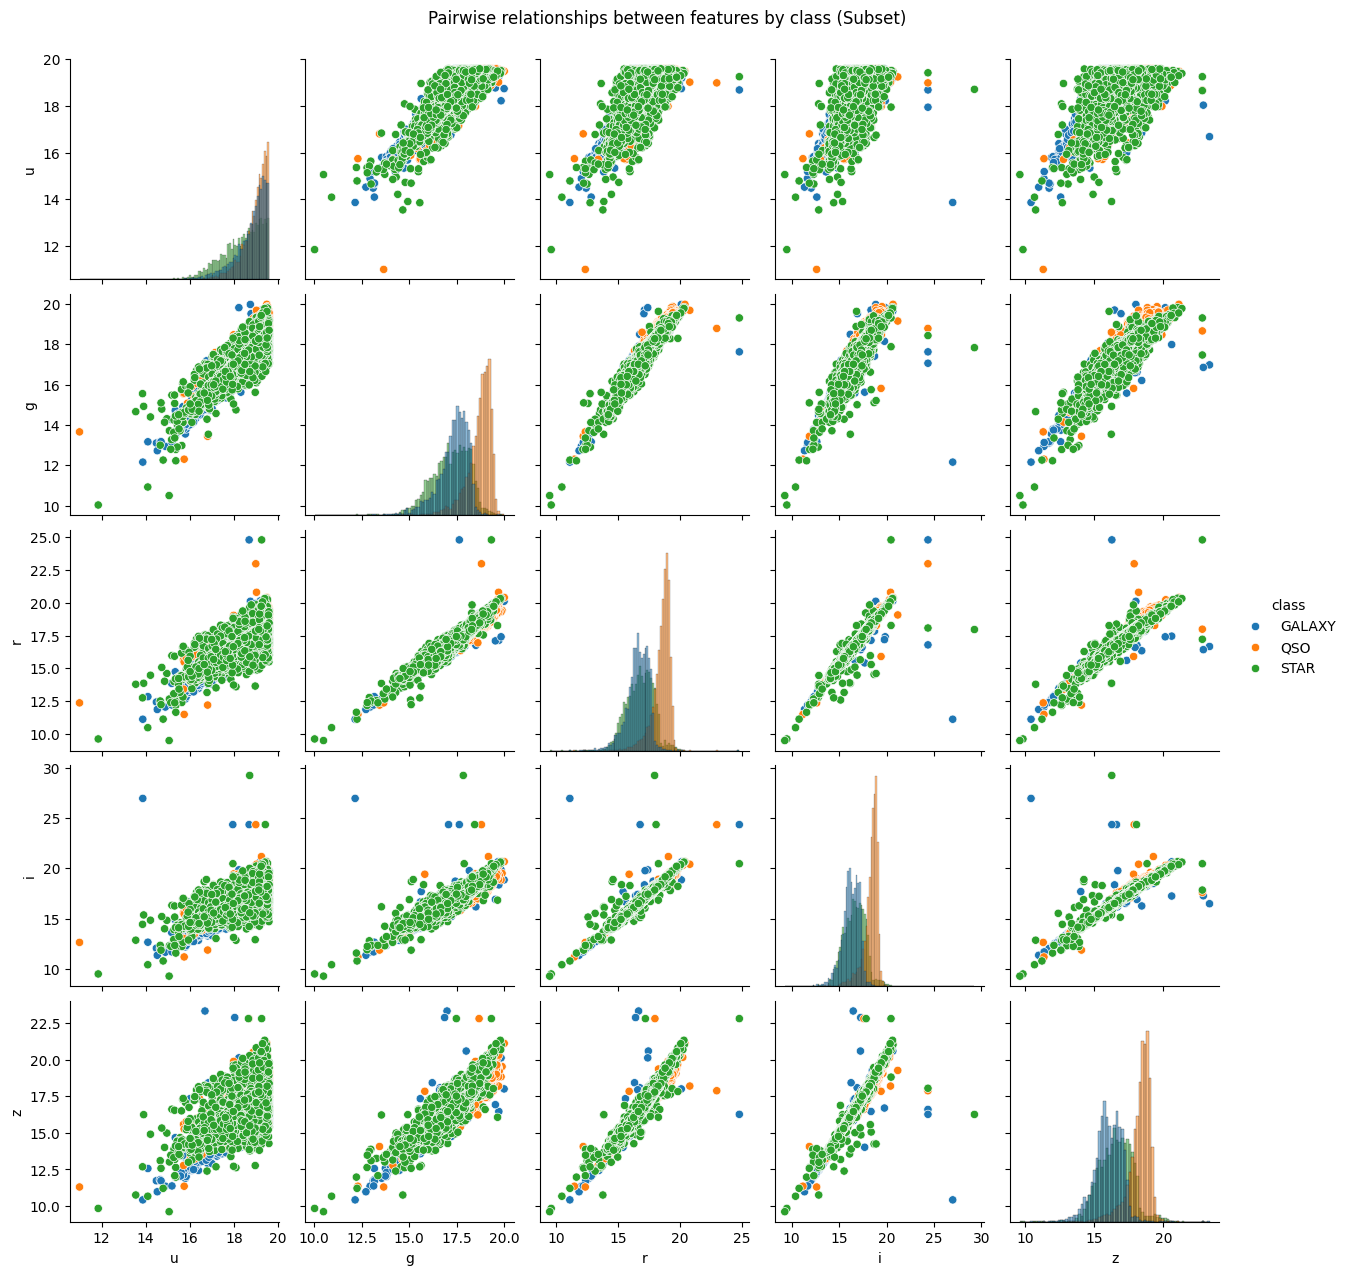

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
subset_size = 15000

df_subset = (
    df.groupby('class', group_keys=False, as_index=False)
      .sample(n=min(subset_size // df['class'].nunique(), df['class'].value_counts().min()), random_state=42)
)

sns.pairplot(df_subset, vars=features, hue='class', diag_kind='hist')
plt.suptitle('Pairwise relationships between features by class (Subset)', y=1.02)
plt.show()

In [6]:
from sklearn.model_selection import train_test_split

x = df[features]
y = df['class_encoded']

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

In [19]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [20]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

y_pred = model.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=le.classes_))

[[47605   724  2115]
 [  695  9846   366]
 [ 2066   381 36202]]
              precision    recall  f1-score   support

      GALAXY       0.95      0.94      0.94     50444
         QSO       0.90      0.90      0.90     10907
        STAR       0.94      0.94      0.94     38649

    accuracy                           0.94    100000
   macro avg       0.93      0.93      0.93    100000
weighted avg       0.94      0.94      0.94    100000



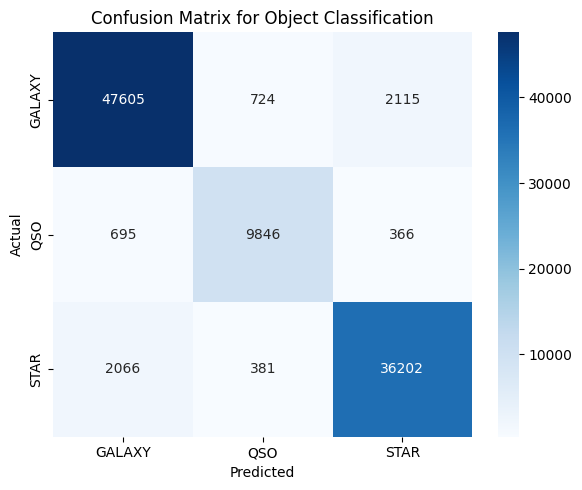

In [21]:
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Object Classification')
plt.tight_layout()
plt.show()

In [22]:
example = X_test.iloc[0]
pred_class = le.inverse_transform(model.predict(example.to_frame().T))[0]

print(f"Example features: {example.to_dict()}")
print(f"Predicted class: {pred_class}")

Example features: {'u': 17.05207, 'g': 15.55575, 'r': 14.86204, 'i': 14.64552, 'z': 14.57039}
Predicted class: STAR
